## Text Analytics
# Mandatory Assignment no. 2
### Student: Alin-Cristian Preda
#### Copenhagen Business School, 2019

In [1]:
# PANDAS
import pandas as pd 
# SYS 
import sys
# SKLEARN 
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
# COLLECTIONS
from collections import Counter
# NLTK 
import nltk
from nltk.corpus import stopwords 
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.corpus.reader import CategorizedPlaintextCorpusReader
# RANDOM
import random
# PRETTY TABLE 
from prettytable import PrettyTable
# TEXTWRAP
import textwrap 
# MATPLOTLIB
import matplotlib.pyplot as plt

## Introduction

"""

#### Method
Naïve Bayes is a classification method based on Bayes’ theorem that derives the probability of the given feature vector being associated with a label. Naïve Bayes has a naive assumption of conditional independence for every feature, which means that the algorithm expects the features to be independent which not always is the case.

Logistic regression is a linear classification method that learns the probability of a sample belonging to a certain class. Logistic regression tries to find the optimal decision boundary that best separates the classes.

#### Learning mechanisms 
The learning mechanism is a bit different between the two models, where Naive Bayes is a generative model and Logistic regression is a discriminative model. What does this mean?

Generative model: Naive Bayes models the joint distribution of the feature X (or d) and target Y (or c), and then predicts the posterior probability given as P(y|x)

Discriminative model: Logistic regression directly models the posterior probability of P(y|x) by learning the input to output mapping by minimising the error.

#### Assumptions
Naïve Bayes assumes all the features to be conditionally independent. So, if some of the features are in fact dependent on each other (in case of a large feature space), the prediction might be poor.
Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated.

#### Tips for improvement
Naïve Bayes: When the training data size is small relative to the number of features, the information/data on prior probabilities help in improving the results
Logistic regression: When the training data size is small relative to the number of features, including regularisation such as Lasso and Ridge regression can help reduce overfitting and result in a more generalised model.

"""

https://dataespresso.com/en/2017/10/24/comparison-between-naive-bayes-and-logistic-regression/

In [2]:
emotions = pd.read_excel(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Diabetes-classification.xlsx" , sheet_name ="Emotions")
emotions.head()

,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Trust,Emotions,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Disgust,Emotions,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Trust,Emotions,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Disgust,Emotions,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Disgust,Emotions,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


In [3]:
journey = pd.read_excel(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Diabetes-classification.xlsx" , sheet_name ="Patient-journey")
journey.head()

,No,discussion_text,Label,ModelName,TextId
0,1,...been on a low-carb diet my blood glucose h...,Living with diabetes - Nutrition,Patient Journey,508e98fc-8db4-4283-a2a4-63c3b70acf86
1,2,A major problem with the American diet is too ...,Living with diabetes - Nutrition,Patient Journey,1349404b-4192-4da2-89ed-346d17351c6b
2,3,Everybody knows that being fat leads to Type 2...,Undiagnosed,Patient Journey,a8961bab-8d57-492e-89b1-07b616a605f1
3,4,For example this diet could help reduce prost...,Living with diabetes - Nutrition,Patient Journey,10628e32-8c12-4c09-b9e0-f98885519c94
4,5,Hi everyone I have T2 diabetes and was diagnos...,Clinical Treatment,Patient Journey,470c5855-24b9-44b3-aedc-c5cf2ed5ed6d


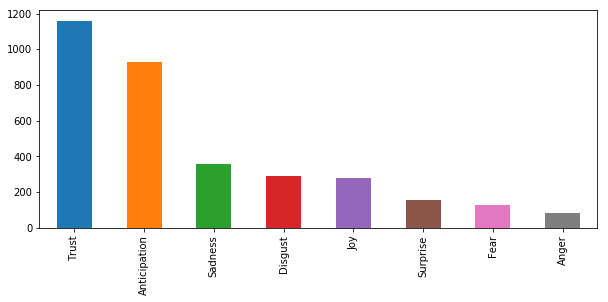

In [4]:
plt.figure(figsize=(10,4))
emotions.Label.value_counts().plot(kind='bar')

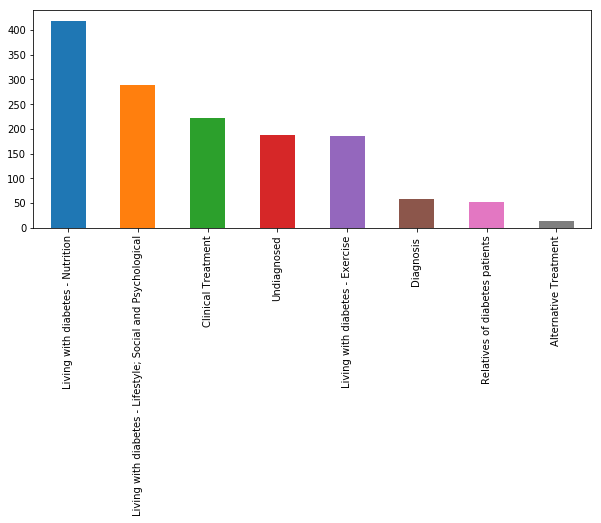

In [5]:
plt.figure(figsize=(10,4))
journey.Label.value_counts().plot(kind='bar');

As can be seen from the plots, the classes are very umbalanced, suggesting that the upcoming models might be biased and thus innacurate. 

### Converting Data Frame to Corpus
Firstly, I need to convert each row of my dataframes to corpus files.

In [10]:
def CreateCorpusFromDataFrame(corpusfolder,df): # The new corpus's path and the data frame it is created from. 
    """
    This function takes a data frame containing text and transforms it into a corpus.
    Each row of the excel becomes a document. 
    The name of the document takes the fileid and the class it belongs to. 
    """
    for index, r in df.iterrows():
        no=r["No"]
        discussion_text=r['discussion_text']
        label=r['Label']
        model_name=r["ModelName"]
        id=r['TextId']
        
        fname=str(label)+'_'+str(id)+'.txt' # Document name practically
        corpusfile=open(corpusfolder+'/'+ fname,'w',encoding="utf-8") # a for appending; creates file if non-existent
        corpusfile.write(str(discussion_text)) # write the document
        corpusfile.close() # and close it 


CreateCorpusFromDataFrame(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Corpora\Diabetes\Emotions",emotions)
CreateCorpusFromDataFrame(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Corpora\Diabetes\Journey",journey)

Secondly, I need to read the files from the corpus folder and then do the NLTK processing required

In [11]:
emotions_corpus=CategorizedPlaintextCorpusReader(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Corpora\Diabetes\Emotions",
r'.*', cat_pattern=r'(.*)_.*') 
journey_corpus=CategorizedPlaintextCorpusReader(r"C:\Users\aleen\Desktop\Data Science\Text Analytics\Assignments\Corpora\Diabetes\Journey",
r'.*', cat_pattern=r'(.*)_.*')

### Checking out the new corporas

Checking to see if we have access.

In [8]:
#emotions_corpus.fileids()
#journey_corpus.fileids()

In [12]:
#print(emotions_corpus.words())
print(emotions_corpus.categories())
#print(journey_corpus.words())
print(journey_corpus.categories())

['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
['Alternative Treatment', 'Clinical Treatment', 'Diagnosis ', 'Living with diabetes - Exercise', 'Living with diabetes - Lifestyle; Social and Psychological', 'Living with diabetes - Nutrition', 'Relatives of diabetes patients', 'Undiagnosed']


### Document Lists

In [13]:
def CreateDocumentsList(corpus):
    """
    Creates a list consisting of tuples of the corpus's 
    documents' file id's and of the category they belong to.
    Each document is a text comment and is associated with a 
    specific emotion or patient journey.
    """
    documents = [(list(corpus.words(fileid)), category) # List comprehension
                 for category in corpus.categories()
                 for fileid in corpus.fileids(category)]
    random.shuffle(documents) # The documents are shuffled randomly, so they are not in a particular order. 
    return documents

# We create a list of the documents neccesary for each model.
emotions_list = CreateDocumentsList(emotions_corpus)
journey_list = CreateDocumentsList(journey_corpus)
print("Total documents in emotions corpus: ",len(emotions_list))
print("Total documents in journey corpus: ", len(journey_list))
print('Total words from Emotions corpus: ', len(emotions_corpus.words()))
print('Total words from Patient Journey corpus: ', len(journey_corpus.words()))

Total documents in emotions corpus:  3386
Total documents in journey corpus:  1426
Total words from Emotions corpus:  293800
Total words from Patient Journey corpus:  123980


### Word Frequency Distribution
Load all words from all the documents to use most common words as features. 

In [14]:
def CreateFeaturesList(corpus, most_freq_no):
    """
    This function creates a frequency distribution from a bag of words, 
    then stores the n most frequent ones and returns them as a list of features.
    """
    all_words = nltk.FreqDist(w.lower() for w in corpus.words()) # Frequenncy distribution of bag of words creates a tuple.
    most_freq_words = all_words.most_common(most_freq_no) # The most common words and their counter. 
    word_features = [word for (word, count) in most_freq_words] # Just the words, to be used as features. 
    return word_features

# Using the function to create feature lists 
emotions_word_features = CreateFeaturesList(emotions_corpus, 3000)
journey_word_features = CreateFeaturesList(journey_corpus, 2000)
# Testing
emotions_word_features[:5] 

['i', '..', 'and', 'the', 'to']

### Generating Set containing Features

In [15]:
def GetDocumentFeatures(document, word_features):
    """
    This function will convert given document into a feature set.
    Returns a dictionary whose keys are the features of the corpus 
    and the values are binary True or False.
    """
    document_words = set(document)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in document_words)
    return features

# Let's try out one of the documents from Emotions as an example: 
words_doc = emotions_corpus.words('Anger_0cbbf7fb-6ff0-4a56-a5c9-510247c70d9d.txt')
# Call the function
feat_dict = GetDocumentFeatures(words_doc,emotions_word_features)
print(len(feat_dict)) # 3000, this is good.
# Let's take just the first 20 as an example.
feat_dict_20 = {k: feat_dict[k] for k in list(feat_dict.keys())[:20]}
print('Transformed document features; printing the first 20 features \n\n', feat_dict_20)

3000
Transformed document features; printing the first 20 features 

 {'contains(i)': False, 'contains(..)': True, 'contains(and)': True, 'contains(the)': True, 'contains(to)': True, 'contains(a)': True, 'contains(diabetes)': True, 'contains(of)': True, "contains(')": True, 'contains(.)': True, 'contains(2)': True, 'contains(type)': True, 'contains(is)': True, 'contains(my)': False, 'contains(that)': True, 'contains(have)': False, 'contains(in)': False, 'contains(it)': True, 'contains(with)': True, 'contains(-)': False}


In [19]:
def CreateFeatureSets(documents_list, word_features):
    """ 
    Creates a set of the features to be used in classification modelling. 
    """
    # For each document in the list, featuresets appends a tuple with the 
    featuresets = [(GetDocumentFeatures(d, word_features), c) for (d,c) in documents_list]
    return featuresets
emotion_featuresets = CreateFeatureSets(emotions_list, emotions_word_features)
journey_featuresets = CreateFeatureSets(journey_list, journey_word_features)

# Testing
emotion_featuresets[:1] # A list of tuples (dictionary[feature]:T/F, category) for each document. 
# Same lengths as the document lists. Thus, a featureset for each document. 
print(len(emotion_featuresets))
print(len(journey_featuresets))

3386
1426


In [17]:
# DOCUMENT/LABELS LIST 
def CreateDocumentsLabels(corpus):
    """
    Creates category mapping and then:
    creates two lists: one consisting of documents
    and one consisting of categories (labels) of a specified corpus.
    """
    index = 0
    cat_mapping = {}
    for cat in corpus.categories():
        cat_mapping[str(cat)] = index
        index += 1
    #print(cat_mapping)
    corpus_docs = []
    corpus_labels = []
    for category in cat_mapping:
        for fileid in corpus.fileids(category):
            corpus_docs.append(corpus.raw(fileids = fileid))
            corpus_labels.append(cat_mapping[category])
    return (corpus_docs, corpus_labels, cat_mapping)

In [18]:
# CREATING LISTS OF DOCUMENTS AND LABELS 
emotions_documents = CreateDocumentsLabels(emotions_corpus)[0]
emotions_labels = CreateDocumentsLabels(emotions_corpus)[1]
journey_documents = CreateDocumentsLabels(journey_corpus)[0]
journey_labels = CreateDocumentsLabels(journey_corpus)[1]
# TRAIN/TEST SPLIT
emotions_xTrain, emotions_xTest, emotions_yTrain, emotions_yTest = train_test_split(emotions_documents, emotions_labels)
journey_xTrain, journey_xTest, journey_yTrain, journey_yTest = train_test_split(journey_documents, journey_labels)

## Multinomial Naive Bayes

In [20]:
def CreateNBPipeline(corpus):
    """
    This is a convenience function for simplifying pipeline creation for multiple corpora.
    """
    pipe_clf = Pipeline( # Applies a sequence of transformations and a final estimator
        # Lists of (name,transformation) tuples. 
    [('vect', CountVectorizer(decode_error='ignore', # Regarding errors raised when encountering characters in different encoding.
                              stop_words='english', # We remove redundant words.
                              max_features=100)), # Not the vocabulary size.
     ('tfidf', TfidfTransformer()), # tf=term frequency, i=times,df=document frequency
     ('clf', MultinomialNB())])
    return pipe_clf

# Pipeline creation
emotions_NBpipeline = CreateNBPipeline(emotions_xTrain)
journey_NBpipeline = CreateNBPipeline(journey_xTrain)
# Fitting pipelines
NB_emotions = emotions_NBpipeline.fit(emotions_xTrain, emotions_yTrain)
NB_journey = journey_NBpipeline.fit(journey_xTrain, journey_yTrain)
# Creating predictions 
emotions_NBpredictions = NB_emotions.predict(emotions_xTest)
journey_NBpredictions = NB_journey.predict(journey_xTest)
# Getting that accuracy score
print('Accuracy of Emotions NB :', accuracy_score(emotions_yTest, emotions_NBpredictions))
print('Accuracy of Journey NB :', accuracy_score(journey_yTest, journey_NBpredictions))

Accuracy of Emotions NB : 0.3246753246753247
Accuracy of Journey NB : 0.4789915966386555


Through the pipeline, I get much higher accuracy scores, but cannot benefit from the most informative features.

### Some helper functions

In [24]:
def get_key_categories(dict, value):
    """Return key of the dictionary."""
    if not value.isdigit():
        return None
    
    for key, val in dict.items():
        if val == int(value):
            return key
    
    return None

In [25]:
def get_most_informative_features(clf, vectorizer, 
                                  label_names, 
                                  max_number_informative_features):
    """
    Prints features with the highest coefficient values, per class
    """
    output = []

    
    try:
        feature_names = vectorizer.get_feature_names()

        label_index = len(label_names)
        
        if label_index == 2:
            label_index = 1
            print('features for binary classification!')
        
        for index in range(label_index):
            #print(str(index) + label_names[index])
            #print('clf.coef_:',len(clf.coef_))
            
            output.append('\n' + label_names[index] + ':\n')
            
            coefs_with_fns = sorted(zip(clf.coef_[index], feature_names))
            
            #print(coefs_with_fns)
            
            threshold = int(max_number_informative_features / 2)

            top = zip(coefs_with_fns[:threshold],
                      coefs_with_fns[:-(threshold + 1):-1])
            
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                feat = "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
                output.append(feat)
            
            #print('\n'.join(output))
                
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise 
        return '\n'.join(output)

    return '\n'.join(output)


### Informative Measures 

In [29]:
def CreatePrettyTableNBMeasuresInfo(corpus, corpus_pipeline, yTest, predictions):
    """
    Creates a pretty table with the measures info for the specified corpora.
    """
    measures_info = metrics.classification_report(yTest, predictions, output_dict=True)
    tab = PrettyTable(['Label', 'Precision', 'Recall', 'f1-score', 'support'])
    
    for key, value in measures_info.items():
        if key.isdigit():
            label = get_key_categories(CreateDocumentsLabels(corpus)[2], key)
            tab.add_row([label, round(value['precision'],3), round(value['recall'],3), round(value['f1-score'],3), value['support']])
        else:
            tab.add_row([key, round(value['precision'],3), round(value['recall'],3), round(value['f1-score'],3), value['support']])
    print(tab,"\n")
    
    vectorizer = corpus_pipeline.named_steps['vect']
    clf = corpus_pipeline.named_steps['clf']
    feature_names = vectorizer.get_feature_names()
    imp_features = get_most_informative_features(clf, vectorizer,list(CreateDocumentsLabels(corpus)[2]), 10)
    print('\nLenght of coeffients: ', len(clf.coef_[0]), '\n\n') # also print clf.coef_ optionally
    print('Lenght of intercepts: ', len(clf.intercept_), '\n\n', clf.intercept_)
    print('\nMost important features\n', imp_features)


CreatePrettyTableNBMeasuresInfo(emotions_corpus, emotions_NBpipeline, emotions_yTest, emotions_NBpredictions)
CreatePrettyTableNBMeasuresInfo(journey_corpus, journey_NBpipeline, journey_yTest, journey_NBpredictions)   

+--------------+-----------+--------+----------+---------+
|    Label     | Precision | Recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|    Anger     |    0.0    |  0.0   |   0.0    |    23   |
| Anticipation |    0.25   | 0.028  |  0.051   |   247   |
|   Disgust    |    0.0    |  0.0   |   0.0    |    80   |
|     Fear     |    0.0    |  0.0   |   0.0    |    30   |
|     Joy      |    0.0    |  0.0   |   0.0    |    63   |
|   Sadness    |    0.0    |  0.0   |   0.0    |    74   |
|   Surprise   |    0.0    |  0.0   |   0.0    |    51   |
|    Trust     |   0.327   | 0.961  |  0.488   |   279   |
|  micro avg   |   0.325   | 0.325  |  0.325   |   847   |
|  macro avg   |   0.072   | 0.124  |  0.067   |   847   |
| weighted avg |   0.181   | 0.325  |  0.176   |   847   |
+--------------+-----------+--------+----------+---------+ 


Lenght of coeffients:  100 


Lenght of intercepts:  8 

 [-3.7123912  -1.31596328 -2.47823342 -3.24440573 -2.46

## Logistic Regression

### Creating a Pipeline 
The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [27]:
def CreateLRPipeline(corpus):
    """
    This is a convenience function for simplifying pipeline creation for multiple corpora.
    """
    pipe_clf = Pipeline( # Applies a sequence of transformations and a final estimator
        # Lists of (name,transformation) tuples. 
    [('vect', CountVectorizer(decode_error='ignore', # Regarding errors raised when encountering characters in different encoding.
                              stop_words='english', # We remove redundant words.
                              max_features=100)), # Not the vocabulary size.
     ('tfidf', TfidfTransformer()), # tf=term frequency, i=times,df=document frequency
     ('clf', LogisticRegression( penalty='l2', solver='lbfgs', max_iter = 1000,
                                dual=False, multi_class='multinomial', tol=1e-3)), # Some parameters are not clear to me so I chose "default" ones from class.
     ])
    return pipe_clf

# Pipeline creation
emotions_LRpipeline = CreateLRPipeline(emotions_corpus)
journey_LRpipeline = CreateLRPipeline(journey_corpus)
# Fitting pipelines
LR_emotions = emotions_LRpipeline.fit(emotions_xTrain, emotions_yTrain)
LR_journey = journey_LRpipeline.fit(journey_xTrain, journey_yTrain)
# Creating predictions 
emotions_LRpredictions = LR_emotions.predict(emotions_xTest)
journey_LRpredictions = LR_journey.predict(journey_xTest)
# Getting that accuracy score
print('Accuracy of Emotions LR :', accuracy_score(emotions_yTest, emotions_LRpredictions))
print('Accuracy of Journey LR :', accuracy_score(journey_yTest, journey_LRpredictions))

Accuracy of Emotions LR : 0.2833530106257379
Accuracy of Journey LR : 0.5546218487394958


We get much greater accuracy scores than with the Multinomial Naive Bayes, in each corpus, altough the one for emotions is still weaker than the one for patient journey. This tells me that the emotions dataset is inherently more complex in its true nature and harder to classify accurately. 

### Informative measures

In [28]:
def CreatePrettyTableLRMeasuresInfo(corpus, corpus_pipeline, yTest, predictions):
    """
    Creates a pretty table with the measures info for the specified corpora.
    """
    measures_info = metrics.classification_report(yTest, predictions, output_dict=True)
    tab = PrettyTable(['Label', 'Precision', 'Recall', 'f1-score', 'support'])
    
    for key, value in measures_info.items():
        if key.isdigit():
            label = get_key_categories(CreateDocumentsLabels(corpus)[2], key)
            tab.add_row([label, round(value['precision'],3), round(value['recall'],3), round(value['f1-score'],3), value['support']])
        else:
            tab.add_row([key, round(value['precision'],3), round(value['recall'],3), round(value['f1-score'],3), value['support']])
    print(tab,"\n")

    vectorizer = corpus_pipeline.named_steps['vect']
    clf = corpus_pipeline.named_steps['clf']
    feature_names = vectorizer.get_feature_names()
    imp_features = get_most_informative_features(clf, vectorizer,list(CreateDocumentsLabels(corpus)[2]), 10)
    print('\nLenght of coeffients: ', len(clf.coef_[0]), '\n\n') # also print clf.coef_ optionally
    print('Lenght of intercepts: ', len(clf.intercept_), '\n\n', clf.intercept_)
    print('\nMost important features\n', imp_features)


CreatePrettyTableLRMeasuresInfo(emotions_corpus, emotions_LRpipeline, emotions_yTest, emotions_LRpredictions)
CreatePrettyTableLRMeasuresInfo(journey_corpus, journey_LRpipeline, journey_yTest, journey_LRpredictions)        

C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


+--------------+-----------+--------+----------+---------+
|    Label     | Precision | Recall | f1-score | support |
+--------------+-----------+--------+----------+---------+
|    Anger     |    0.0    |  0.0   |   0.0    |    23   |
| Anticipation |   0.236   | 0.223  |  0.229   |   247   |
|   Disgust    |    1.0    | 0.013  |  0.025   |    80   |
|     Fear     |    0.0    |  0.0   |   0.0    |    30   |
|     Joy      |    0.0    |  0.0   |   0.0    |    63   |
|   Sadness    |    0.0    |  0.0   |   0.0    |    74   |
|   Surprise   |    0.0    |  0.0   |   0.0    |    51   |
|    Trust     |   0.302   | 0.659  |  0.414   |   279   |
|  micro avg   |   0.283   | 0.283  |  0.283   |   847   |
|  macro avg   |   0.192   | 0.112  |  0.084   |   847   |
| weighted avg |   0.263   | 0.283  |  0.206   |   847   |
+--------------+-----------+--------+----------+---------+ 


Lenght of coeffients:  100 


Lenght of intercepts:  8 

 [-1.34190471  1.25673612 -0.21054448 -0.77786111  0.08

## Alternative method for Naive Bayes

In [31]:
def CreateTrainTestSet(featuresets, index):
    """
    Creates a training set starting at index. 
    And a test set ending at intex.
    """ 
    # Used index because different corpora have different length feature sets. 
    train_set= featuresets[index:]
    test_set= featuresets[:index]
    return (train_set, test_set)

# I tried to roughly give the training sets and test sets 90% and 10% respectively, by approximating the index. 
emotions_train_set, emotions_test_set = CreateTrainTestSet(emotion_featuresets, 340)[0], CreateTrainTestSet(emotion_featuresets, 340)[1]
journey_train_set, journey_test_set = CreateTrainTestSet(journey_featuresets, 140)[0], CreateTrainTestSet(journey_featuresets, 140)[1]
# Testing
l1 = len(emotions_train_set)
l2 = len(emotions_test_set)
print(l1,l2,l1+l2)

3046 340 3386


### Training Naive Bayes Classifier
Now I have everything I need to get started with the supervised learning process. through training.

In [36]:
NB_emotions = nltk.NaiveBayesClassifier.train(emotions_train_set)
NB_journey = nltk.NaiveBayesClassifier.train(journey_train_set)

In [44]:
print("Accuracy of Multinomial Naibe Bayes on Emotions corpus: ",nltk.classify.accuracy(NB_emotions, emotions_test_set)) 
NB_emotions.show_most_informative_features(100)

Accuracy of Multinomial Naibe Bayes on Emotions corpus:  0.17352941176470588
Most Informative Features
         contains(shift) = True            Anger : Trust  =     22.0 : 1.0
      contains(reaction) = True            Anger : Trust  =     22.0 : 1.0
          contains(hold) = True            Anger : Trust  =     22.0 : 1.0
         contains(local) = True            Anger : Trust  =     22.0 : 1.0
         contains(lover) = True            Anger : Trust  =     22.0 : 1.0
    contains(discussion) = True            Anger : Trust  =     22.0 : 1.0
         contains(bacon) = True            Anger : Trust  =     22.0 : 1.0
   contains(progression) = True            Anger : Trust  =     22.0 : 1.0
         contains(crazy) = True             Fear : Trust  =     20.1 : 1.0
        contains(stated) = True             Fear : Trust  =     20.1 : 1.0
            contains(38) = True             Fear : Trust  =     20.1 : 1.0
    contains(incredibly) = True            Anger : Antici =     17.7 : 1

So the feature "quickly" appears in Surprise texts 12.4 times more than in Anticipation texts. That makes sense. Baccon is one of the features most associated with anger. After a simpel Google search of "diabetes baccon", one can quickly find out that bacon is one of the worst dishes for people suffering of this condition. Crazy is commonly associated with Fear ("I am going crazy" type of expressions might be common.) 

In [45]:
print("Accuracy of Multinomial Naibe Bayes on Journey corpus: ",nltk.classify.accuracy(NB_journey, journey_test_set)) 
NB_journey.show_most_informative_features(100)

Accuracy of Multinomial Naibe Bayes on Journey corpus:  0.42857142857142855
Most Informative Features
     contains(therapies) = True           Altern : Living =     53.5 : 1.0
        contains(called) = True           Altern : Living =     41.2 : 1.0
       contains(natural) = True           Altern : Living =     35.1 : 1.0
    contains(treatments) = True           Altern : Living =     35.1 : 1.0
        contains(bitter) = True           Altern : Living =     32.1 : 1.0
          contains(open) = True           Altern : Living =     32.1 : 1.0
    contains(additional) = True           Altern : Living =     32.1 : 1.0
      contains(improves) = True           Altern : Living =     32.1 : 1.0
    contains(colleagues) = True           Altern : Living =     32.1 : 1.0
         contains(india) = True           Altern : Living =     32.1 : 1.0
          contains(onto) = True           Altern : Living =     32.1 : 1.0
        contains(nausea) = True           Altern : Living =     32.1 : 1.

India is a very common word in alternative treatment comments, which makes sense, knowing that many spiritual healers and gurus hail their knowledge from sacred Indian traditions. Bitter might also be a word associated with the alternative medicine. The same foes for "natural".

### Testing the classifier
The first sample comment is hand written by me and it tests what the classifier does with it. The result is Anticipation.

In [39]:
sample_comment = 'i have diabetes and I am so happy but you see the thing is I hate not being able to eat bacon anymore.'

sample_comment_feats = GetDocumentFeatures(sample_comment.split(), emotions_word_features)

#print('Sample comment features: \n\n',sample_comment_feats)

print('Result of sample comment: ', NB_emotions.classify(sample_comment_feats))

Result of sample comment:  Anticipation


The second example uses the file that we used before, rightly putting it into the Anger class.

In [41]:
sample_comment = emotions_corpus.words('Anger_0cbbf7fb-6ff0-4a56-a5c9-510247c70d9d.txt')

sample_comment_feats = GetDocumentFeatures(sample_comment, emotions_word_features)

#print('Sample comment features: \n\n',sample_comment_feats)

print('Result of sample comment: ', NB_emotions.classify(sample_comment_feats))

Result of sample comment:  Anger


A third example uses a hand-written sentence which is undoubtedly negative. The result is innaccurate to say the least...

In [42]:
sample_comment = "i fear for my life i don't know what to do i am so scared"

sample_comment_feats = GetDocumentFeatures(sample_comment.split(), emotions_word_features)

#print('Sample comment features: \n\n',sample_comment_feats)

print('Result of sample comment: ', NB_emotions.classify(sample_comment_feats))

Result of sample comment:  Trust


## Commenting on the performance of the classifiers

In [ ]:
### MNB
#### Emotions
             | Precision | Recall | f1-score | support
Anticipation |    0.25   | 0.028  |  0.051   |   247  
   Trust     |   0.327   | 0.961  |  0.488   |   279 
#### Journey
                                                           | Precision | Recall | f1-score | support
Clinical Treatment                                         |   0.688   | 0.328  |  0.444   |    67  
Living with diabetes - Exercise                            |   0.824   | 0.275  |  0.412   |    51
Living with diabetes - Lifestyle; Social and Psychological |   0.413   | 0.528  |  0.463   |    72
Living with diabetes - Nutrition                           |   0.458   | 0.879  |  0.602   |    99
Undiagnosed                                                |   0.385   | 0.222  |  0.282   |    45

### LR
#### Emotions
             | Precision | Recall | f1-score | support
Anticipation |   0.236   | 0.223  |  0.229   |   247
Disgust      |    1.0    | 0.013  |  0.025   |    80
Trust        |   0.302   | 0.659  |  0.414   |   279
#### Journey
                                                           | Precision | Recall | f1-score | support
Clinical Treatment                                         |   0.569   | 0.433  |  0.492   |    67
Diagnosis                                                  |   0.667   |  0.2   |  0.308   |    10
Living with diabetes - Exercise                            |   0.786   | 0.431  |  0.557   |    51
Living with diabetes - Lifestyle; Social and Psychological |   0.408   | 0.583  |  0.480   |    72 
Living with diabetes - Nutrition                           |   0.654   | 0.838  |  0.735   |    99
Undiagnosed                                                |   0.455   | 0.444  |  0.449   |    45

Generally, LR has greater f1-scores on the classes. It also manages to capture more classes (Disgust for Emotions and Diagnosis for Journey).

Regarding the accuracy of the models used in the pipelines:

Accuracy of Emotions NB : 0.3246753246753247; Accuracy of Journey NB : 0.4789915966386555

Accuracy of Emotions LR : 0.2833530106257379; Accuracy of Journey LR : 0.5546218487394958

LR scores higher for Journey but lower for Emotions. Generally, the models score much lower for Emotions than for Journey.

The most important features presented above from the pretty table functions are strikingly different between NB and LR.